# **Lab 4: Multi-Layer Perceptron**
**Name(s):** Luke Voinov, Tiffany Nguyen Emmanuel Garcia, Nimai Keshu

We use the US Census dataset:

https://www.kaggle.com/muonneutrino/us-census-demographic-data/data

##### **Classification Task:**

The classification task you will be performing is to predict, **for each tract, what the child poverty rate will be**. You will need to convert this from regression to four levels of classification by quantizing the variable of interest.

In [34]:

# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit


### **1. Load, Split, and Balance**

*1.1. Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features until asked to do so later in the rubric.*

In [7]:
path = "/Users/tiffany/Desktop/CS 5324/Lab 4/acs2017_census_tract_data.csv"
df = pd.read_csv(path)

df.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74001 entries, 0 to 74000
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TractId           74001 non-null  int64  
 1   State             74001 non-null  object 
 2   County            74001 non-null  object 
 3   TotalPop          74001 non-null  int64  
 4   Men               74001 non-null  int64  
 5   Women             74001 non-null  int64  
 6   Hispanic          73305 non-null  float64
 7   White             73305 non-null  float64
 8   Black             73305 non-null  float64
 9   Native            73305 non-null  float64
 10  Asian             73305 non-null  float64
 11  Pacific           73305 non-null  float64
 12  VotingAgeCitizen  74001 non-null  int64  
 13  Income            72885 non-null  float64
 14  IncomeErr         72885 non-null  float64
 15  IncomePerCap      73256 non-null  float64
 16  IncomePerCapErr   73256 non-null  float6

*1.2 Remove any observations that having missing data.*

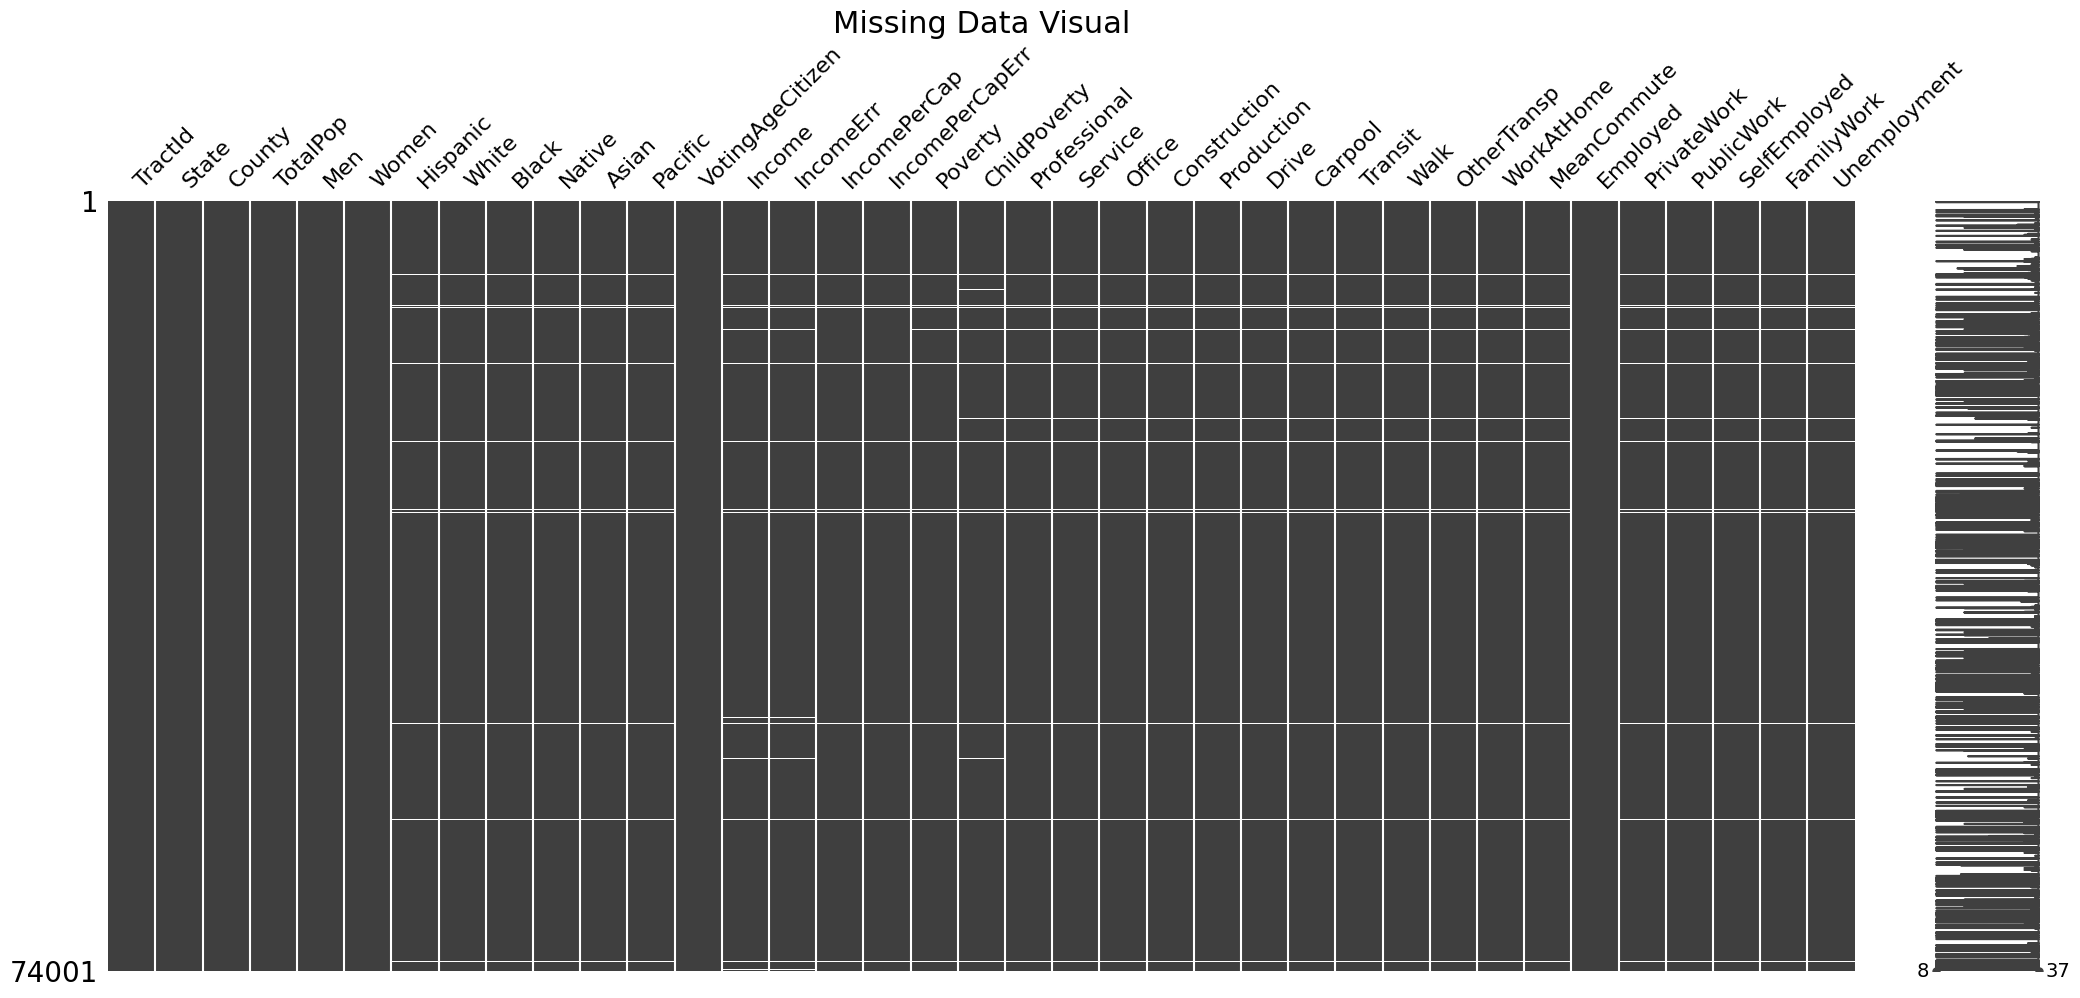

In [9]:
"""
Visualize missing data
"""

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# External package: conda install missingno 
import missingno as mn

mn.matrix(df)
plt.title("Missing Data Visual",fontsize=22)
plt.show()

In [10]:
print(df.isnull().sum())  # Shows the count of missing values per column

TractId                0
State                  0
County                 0
TotalPop               0
Men                    0
Women                  0
Hispanic             696
White                696
Black                696
Native               696
Asian                696
Pacific              696
VotingAgeCitizen       0
Income              1116
IncomeErr           1116
IncomePerCap         745
IncomePerCapErr      745
Poverty              842
ChildPoverty        1110
Professional         811
Service              811
Office               811
Construction         811
Production           811
Drive                801
Carpool              801
Transit              801
Walk                 801
OtherTransp          801
WorkAtHome           801
MeanCommute          946
Employed               0
PrivateWork          811
PublicWork           811
SelfEmployed         811
FamilyWork           811
Unemployment         810
dtype: int64


We can see that no column is missing too much data. Therefore, it is okay to leave these missing values as they are; imputation is not necessary.

In [11]:
"""
Remove all rows that have a population of less than 100 people.
Delete any rows that contain missing data
"""
# keep rows with TotalPop >= 100, reset index
df_mod = df[df['TotalPop'] >= 100].reset_index(drop=True)

# also delete any row that has any missing value
df_clean = df_mod.dropna().reset_index(drop=True)

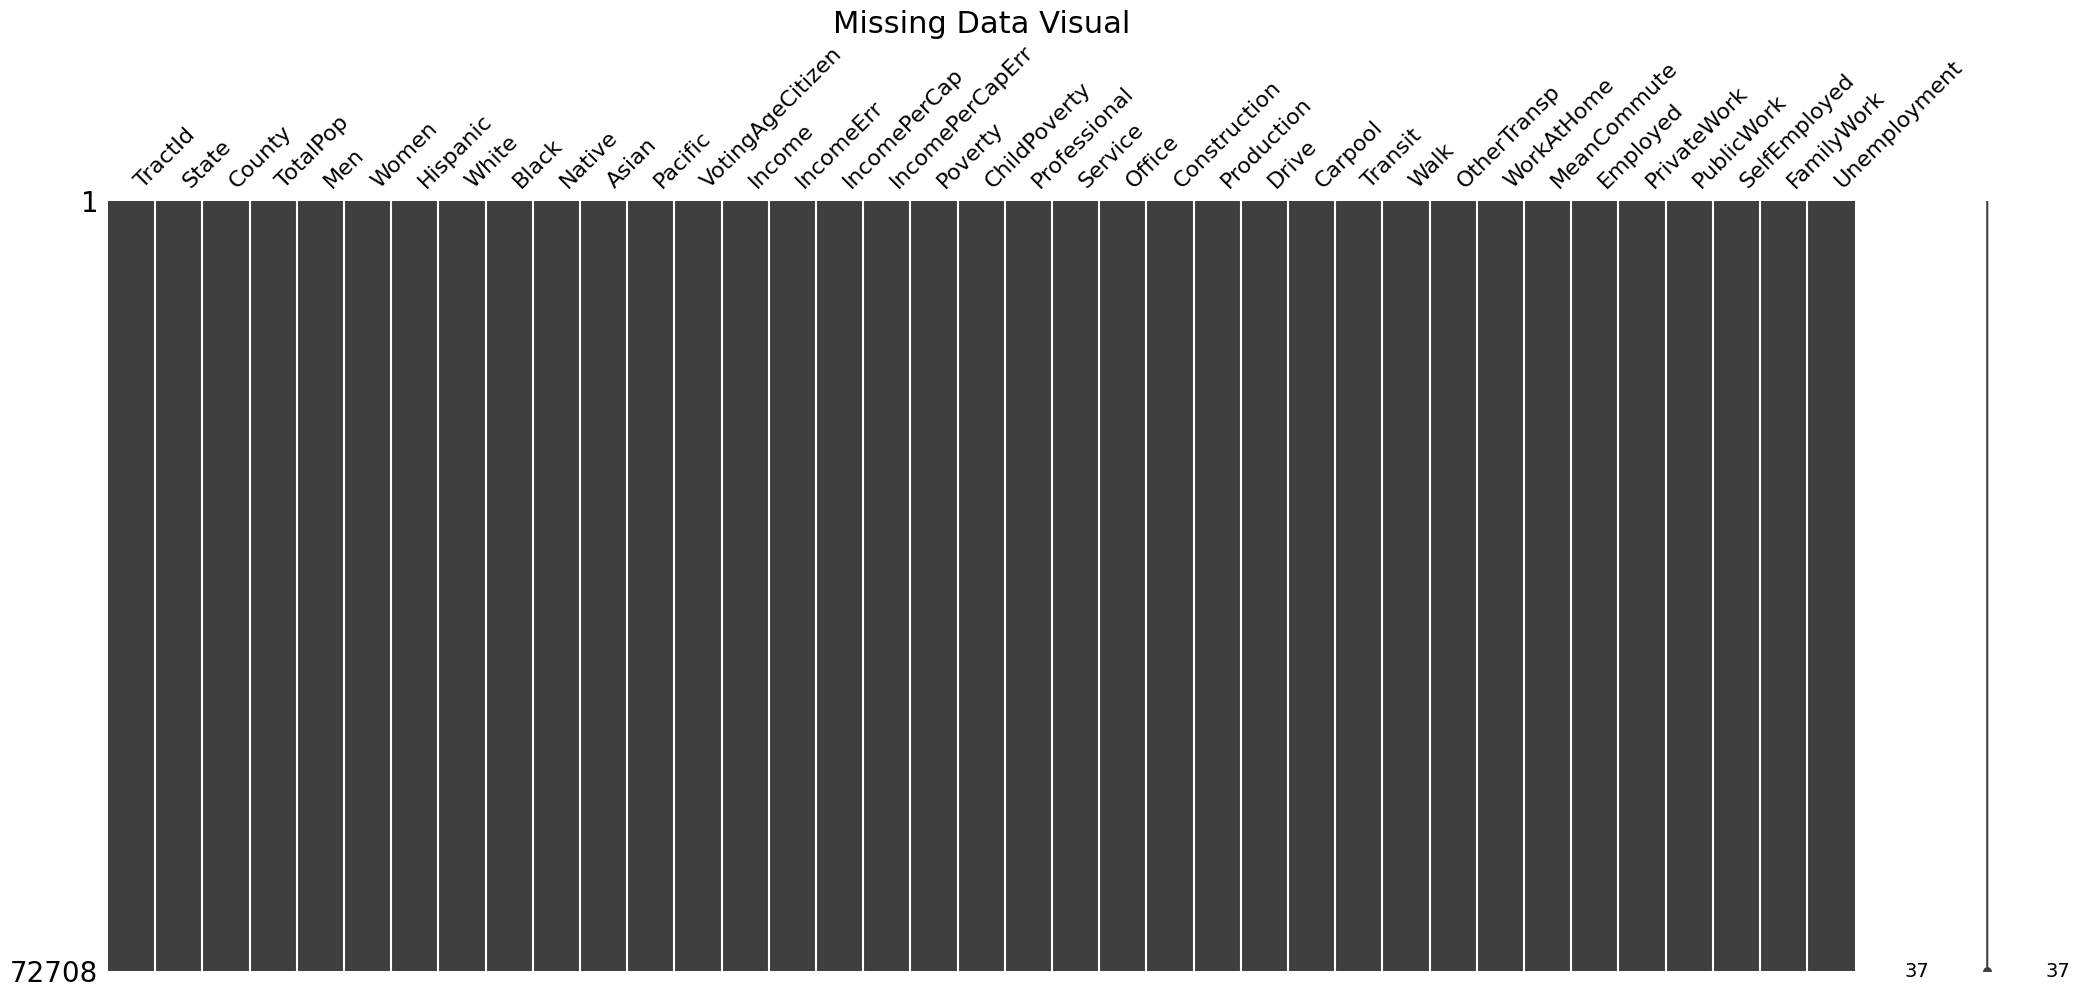

TractId     72708
State       72708
County      72708
TotalPop    72708
Men         72708
dtype: int64

In [12]:
"""
Visualize missing data
"""

import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

# External package: conda install missingno 
import missingno as mn

mn.matrix(df_clean)
plt.title("Missing Data Visual",fontsize=22)
plt.show()


df_clean.count().head()

We started with 74001 and ended with 72708 people. This means that deleting every row with a missing value deleted ~2% of the data. This is small and permits deletion.

*1.3 Encode any string data as integers for now.*

We have already seen that there are only two columns that contain strings: the state and the county

In [13]:
# encode states
states = df_clean['State'].unique()
count = 0

df_state_enc = df_clean
for s in states:
    df_state_enc = df_state_enc.replace(s,count)
    count += 1

print("States encoded to ints:\n", df_state_enc['State'].unique())

# encode counties
counties = df_clean['County'].unique()
count = 0

df_enc = df_state_enc
for c in counties:
    df_enc = df_enc.replace(c,count)
    count += 1

print("Counties encoded to ints:\n", df_enc['County'].unique())


/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_2838/2986858223.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_state_enc = df_state_enc.replace(s,count)


States encoded to ints:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]
Counties encoded to ints:
 [   0    1    2 ... 1950 1951 1952]


/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_2838/2986858223.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_enc = df_enc.replace(c,count)


In [14]:
print(df_enc.info(verbose=False)) # Notice the dtypes
df_enc.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72708 entries, 0 to 72707
Columns: 37 entries, TractId to Unemployment
dtypes: float64(29), int64(8)
memory usage: 20.5 MB
None


,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,0,0,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,0,0,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,0,0,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,0,0,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,0,0,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


1.4 You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable. 

We decided to keep 'county' because we suspect each county will meaningfully inform child poverty rates.

In [15]:
# see how many instances there are for each county
counties = df_enc['County'].unique()
count = 0
num_each_instance = []

for c in counties:
    bools = df_enc['County'] == c
    num_each_instance.append(df_enc.where(bools == True)['County'].count())


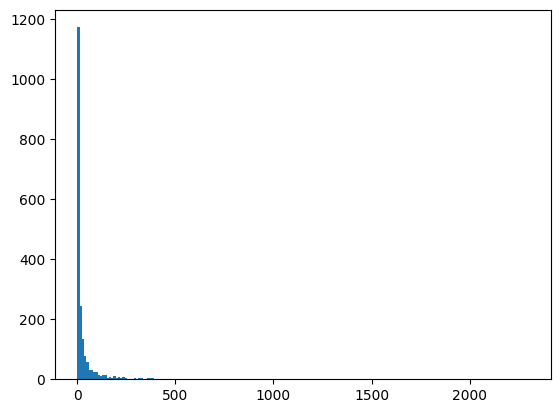

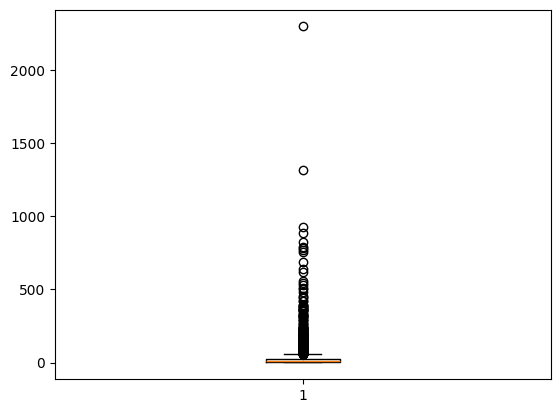

Mean: 37.247950819672134
Median: 9.0


In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(num_each_instance,bins=200)
plt.show()

plt.figure()
plt.boxplot(num_each_instance)
plt.show()

print("Mean:", np.mean(num_each_instance))
print("Median:", np.median(num_each_instance))

Here, as we can see from the graphs, a median is a more representative value due to the tremendous effect of outliers. This median shows that each county has around 9 census tracts, and each census tract has around 1k people. While all the counties are in the same state with the same laws and policies, they can still vary dramatically between each other. As an anecdote, it would be reasonable to suspect that child poverty rates are lower in the Highland Park county as compared to the Oak Cliff county. 

We conclude our decision with a PCA analysis that demonstrate how important of a feature counties are: **CAN I DO THIS**?

The next two requirements will need to be completed together as they might depend on one another. 

*Note: You will need to one hot encode the target, but **do not** one hot encode the categorical data **until** instructed to do so in the lab.*

1.5 Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. One option is to choose quantization thresholds for the "ChildPoverty" variable that equally divide the data into four classes. *Should balancing of the dataset be done for both the training and testing set? Explain.*

We balanced the dataset according to 4 percentiles: 75% > in poverty level = impoverished, 75 - 50 % are poor, 50 - 25 % are well-off, 25 % < are rich. All of these results will be relative to the training data and will equally split 1/4 of the dataset into each class.

The training dataset must be balanced because it will allow us to categorize among the 4 classes. The test dataset should also be balanced to reflect the real-world use case. If it's unbalanced, then a split test case may result in 99% impoverished instances and 1% of the rest, which is inapproprite if we want to test real-life scenarios.





In [17]:
# This code is adapted from github Copilot. 
# It will split the dataset into 4 quartiles and place 25% of the dataset into a quartile for each quartile, thus evenly distributing the data.


q25 = df_enc['ChildPoverty'].quantile(0.25)
q50 = df_enc['ChildPoverty'].quantile(0.50)
q75 = df_enc['ChildPoverty'].quantile(0.75)

# Create balanced classes
def classify_poverty(value):
    if value <= q25:
        return 0  # rich
    elif value <= q50:
        return 1  # well-off
    elif value <= q75:
        return 2  # poor
    else:
        return 3  # impoverished

df_enc['PovertyClass'] = df_enc['ChildPoverty'].apply(classify_poverty)

In [18]:
df_enc['PovertyClass'] 

0        2
1        3
2        2
3        0
4        2
        ..
72703    3
72704    3
72705    3
72706    3
72707    3
Name: PovertyClass, Length: 72708, dtype: int64

1.6 Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing. There is no need to split the data multiple times for this lab.

In [19]:

# This code is adapted from voinov_lab3

from sklearn.preprocessing import StandardScaler

# Drop irrelevent columns and classes from feature list
X = df_enc.drop(columns=["TractId", "ChildPoverty", "PovertyClass"])
y = df_enc["ChildPoverty"]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Previously the quantile included all the data. Now it has to only include 80% of the data. The test quantiles will be the same as the train one to be realistic.
q25 = y_train.quantile(0.25)
q50 = y_train.quantile(0.50)
q75 = y_train.quantile(0.75)

# Now make the classes  
y_train = y_train.apply(classify_poverty).values
y_test = y_test.apply(classify_poverty).values

# Convert to numpy arrays with proper data types. Provided by github copilot to fix type issues
X_train = X_train.astype(np.float32).values
X_test = X_test.astype(np.float32).values

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)


Training set shape: (58166, 35)
Test set shape: (14542, 35)


In [20]:
# LOOK: this is from someone else's lab, works with Tiffany's code
# so we may need to do some revisions in terms of prepping the data

from collections import Counter

X = df_enc.drop(columns=["PovertyClass"]) # features
y = df_enc["PovertyClass"] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

counts_train = Counter(y_train)
min_size = min(counts_train.values())

df_train = pd.concat([X_train, y_train], axis=1)
df_train_balanced = (df_train.groupby('PovertyClass')).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)

X_train_balanced = df_train_balanced.drop(columns=["PovertyClass"])
y_train_balanced = df_train_balanced["PovertyClass"]

print("\nFinal Shapes:")
print("X_train_balanced:", X_train_balanced.shape)
print("y_train_balanced:", y_train_balanced.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

y_train = y_train_balanced
X_train = X_train_balanced


Final Shapes:
X_train_balanced: (57900, 37)
y_train_balanced: (57900,)
X_test: (14542, 37)
y_test: (14542,)


/var/folders/07/1_cm7qnd2mg18rts7n3nf9hw0000gn/T/ipykernel_2838/2298622833.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_balanced = (df_train.groupby('PovertyClass')).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


### **2. Pre-processing and Initial Modeling**

2.1  You will be using a two layer perceptron from class for the next few parts of the rubric. There are several versions of the two layer perceptron covered in class, with example code. When selecting an example two layer network from class be sure that you use: (1) vectorized gradient computation, (2) mini-batching, (3) cross entropy loss, and (4) proper Glorot initialization, at a minimum. There is no need to use momentum or learning rate reduction (assuming you choose a sufficiently small learning rate). **It is recommended to use sigmoids throughout the network, but not required** 

2.2 Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the feature data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs. 

This is based off of the Two Layer Perceptron from Eric Larson's version from the class. We modified it so that we would be able to use minibatches_size as one of the parameters and made it suitable for multi-class classification by using softmax. The mathematics behind is consistently the same as the one in class.

In [21]:
# Imported from 07. MLP Neural Networks.ipynb (Eric Larson, CS 5324/7324)

# Example adapted from https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
# Original Author: Sebastian Raschka

# This is the optional book we use in the course, excellent intuitions and straightforward programming examples
# please note, however, that this code has been manipulated to reflect our assumptions and notation.

class TwoLayerPerceptron:
    def __init__(self, n_hidden=30, C=0.0, epochs=500, eta=0.001, minibatch_size=64, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatch_size = minibatch_size

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation."""
        return pd.get_dummies(y).values.T

    def _initialize_weights(self, n_features, n_output):
        """Initialize weights using Glorot initialization."""
        limit_1 = np.sqrt(6 / (n_features + self.n_hidden))
        limit_2 = np.sqrt(6 / (self.n_hidden + n_output))

        W1 = np.random.uniform(-limit_1, limit_1, (self.n_hidden, n_features + 1))  # +1 for bias term
        W2 = np.random.uniform(-limit_2, limit_2, (n_output, self.n_hidden + 1))  # +1 for bias term
        b1 = np.zeros((self.n_hidden, 1))
        b2 = np.zeros((n_output, 1))

        return W1, W2, b1, b2

    @staticmethod
    def _sigmoid(z):
        """Sigmoid activation function."""
        return expit(z)

    @staticmethod
    def _softmax(z):
        """Softmax activation function (for cross-entropy)."""
        exp_values = np.exp(z - np.max(z, axis=0, keepdims=True))  # stability
        return exp_values / np.sum(exp_values, axis=0, keepdims=True)

    @staticmethod
    def _cross_entropy_loss(Y_enc, A3):
        """Cross-entropy loss function."""
        m = Y_enc.shape[1]
        cost = -np.sum(Y_enc * np.log(A3 + 1e-8)) / m  # add small epsilon for stability
        return cost

    def _cost(self, A3, Y_enc, W1, W2):
        """Compute the cost function with regularization."""
        cost = self._cross_entropy_loss(Y_enc, A3)
        L2_term = self._L2_reg(self.l2_C, W1, W2)
        return cost + L2_term

    def _L2_reg(self, lambda_, W1, W2):
        """Compute L2 regularization cost."""
        return (lambda_ / 2.0) * (np.sum(W1[:, 1:] ** 2) + np.sum(W2[:, 1:] ** 2))

    def _feedforward(self, X, W1, W2, b1, b2):
        """Compute the feedforward step."""
        A1 = self._add_bias_unit(X)
        Z1 = W1 @ A1.T + b1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2.T)  # Add bias to hidden layer
        Z2 = W2 @ A2.T + b2
        A3 = self._softmax(Z2)  # Softmax for classification
        return A1, Z1, A2, Z2, A3

    def _add_bias_unit(self, X):
        """Add bias unit to the input data."""
        ones = np.ones((X.shape[0], 1))
        return np.hstack((ones, X))

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y_enc, W1, W2):
        """Compute gradient step using backpropagation."""
        V2 = A3 - Y_enc  # For cross-entropy loss

        # FIX: Transpose the result of matrix multiplication to match A2's shape
        # Original: V1 = A2 * (1 - A2) * (W2[:, 1:].T @ V2)
        delta = W2[:, 1:].T @ V2
        # A2 shape is (samples, hidden+1), delta shape is (hidden, samples)
        # We need to transpose delta to match A2's shape
        delta_t = delta.T  # Now shape is (samples, hidden)

        # We need to remove the bias column from A2 for element-wise multiplication
        A2_nobias = A2[:, 1:]  # Remove bias column, now shape is (samples, hidden)
        V1 = A2_nobias * (1 - A2_nobias) * delta_t

        # Now calculate gradients with correct shapes
        gradW2 = V2 @ A2
        gradW1 = V1.T @ A1
        gradb2 = np.sum(V2, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1.T, axis=1).reshape((-1, 1))

        # Regularize weights that are not bias terms
        gradW1[:, 1:] += self.l2_C * W1[:, 1:]
        gradW2[:, 1:] += self.l2_C * W2[:, 1:]

        return gradW1, gradW2, gradb1, gradb2

    def fit(self, X, y):
        """Train the model using mini-batches and update weights."""
        Y_enc = self._encode_labels(y)
        n_features = X.shape[1]
        n_output = Y_enc.shape[0]

        # Initialize weights
        W1, W2, b1, b2 = self._initialize_weights(n_features, n_output)

        cost_history = []
        for epoch in range(self.epochs):
            minibatch_cost = 0

            # Shuffle and split the data into mini-batches
            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            Y_enc_shuffled = Y_enc[:, permutation]

            for i in range(0, X.shape[0], self.minibatch_size):
                X_batch = X_shuffled[i:i+self.minibatch_size]
                Y_batch = Y_enc_shuffled[:, i:i+self.minibatch_size]

                # Feedforward
                A1, Z1, A2, Z2, A3 = self._feedforward(X_batch, W1, W2, b1, b2)

                # Compute cost
                minibatch_cost = self._cost(A3, Y_batch, W1, W2)

                # Backpropagation
                gradW1, gradW2, gradb1, gradb2 = self._get_gradient(A1, A2, A3, Z1, Z2, Y_batch, W1, W2)

                # Update weights and biases
                W1 -= self.eta * gradW1
                W2 -= self.eta * gradW2
                b1 -= self.eta * gradb1
                b2 -= self.eta * gradb2

            cost_history.append(minibatch_cost)

        self.W1, self.W2, self.b1, self.b2 = W1, W2, b1, b2
        self.cost_ = cost_history
        return self

    def predict(self, X):
        """Predict class labels."""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2, self.b1, self.b2)
        return np.argmax(A3, axis=0)

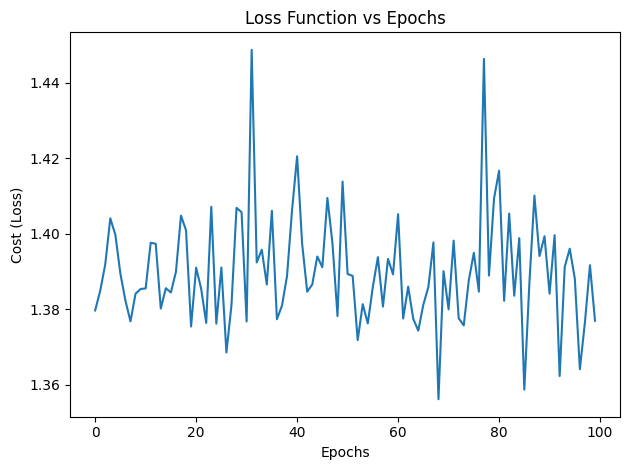

Accuracy: 0.252303672122129


In [22]:
# raw data
tlp_raw = TwoLayerPerceptron(n_hidden=30, epochs=100, eta=0.001, minibatch_size=64)
tlp_raw.fit(X_train.values, y_train.values)

# evaluate on test set
y_pred = tlp_raw.predict(X_test.values)
accuracy = accuracy_score(y_test, y_pred)

plt.plot(range(len(tlp_raw.cost_)), tlp_raw.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost (Loss)")
plt.title("Loss Function vs Epochs")
plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy}")

Based off of the graph above, the values vary between 1.35 and 1.42. The small learning rate and random mini-batch sampling might have likely produced the oscillations. I believe with further tuning with normalization and one-hot encoded is required to achieve stable results.

2.3 Now normalize the continuous numeric feature data

Training Accuracy (Normalized): 0.9950431778929189
Test Accuracy (Normalized): 0.9928483014715995


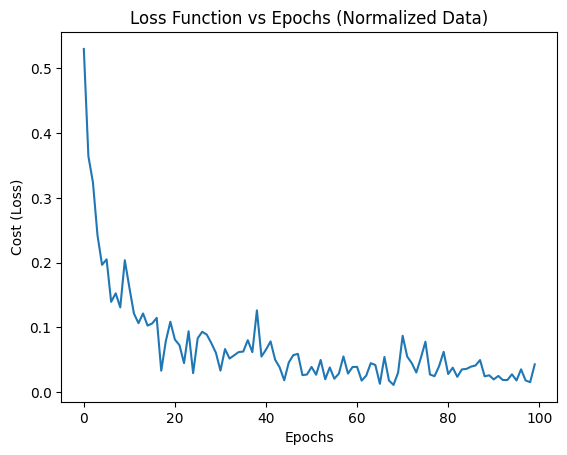

In [23]:
# trying to normalize data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# train and evaluate
tlp_norm = TwoLayerPerceptron(n_hidden=30, epochs=100, eta=0.001, minibatch_size=64)
tlp_norm.fit(X_train_norm, y_train)

# predict and evaluate
y_train_pred_norm = tlp_norm.predict(X_train_norm)
y_test_pred_norm = tlp_norm.predict(X_test_norm)

# calculate accuracy
train_acc_norm = accuracy_score(y_train, y_train_pred_norm)
test_acc_norm = accuracy_score(y_test, y_test_pred_norm)

print(f"Training Accuracy (Normalized): {train_acc_norm}")
print(f"Test Accuracy (Normalized): {test_acc_norm}")

plt.plot(range(len(tlp_norm.cost_)), tlp_norm.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost (Loss)")
plt.title("Loss Function vs Epochs (Normalized Data)")
plt.show()


With the data being normalized, we can see a strong downward trend, starting from 0.6 and dropping within the first 10-20 epochs. There's some loss that stabilizes near 0.05 after around 30 epochs. There aer some small fluctuations after convergence due to the mini-batch stochastic gradient descent, but this is normal. This is definitely an improvement from the previous model.

2.4 One hot encode the categorical feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.  

Training Accuracy (One-Hot Encoded + Normalized): 0.9957167530224525
Test Accuracy (One-Hot Encoded + Normalized): 0.9948425250997112


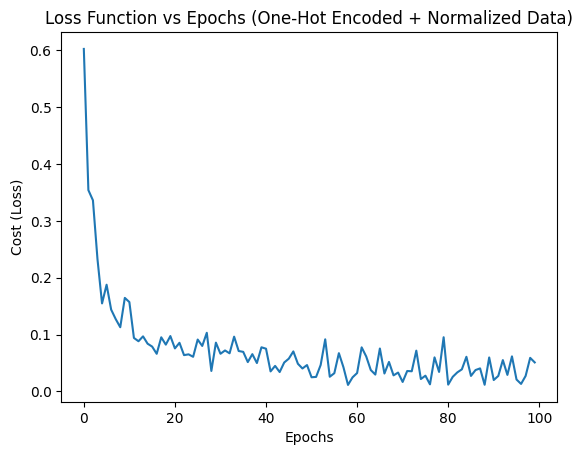

In [24]:
# one-hot encoding categorical features
X_combined = pd.concat([X_train, X_test])
X_combined_encoded = pd.get_dummies(X_combined)

# split back into train and test sets
X_train_onehot = X_combined_encoded.iloc[:len(X_train_balanced)]
X_test_onehot = X_combined_encoded.iloc[len(X_train_balanced):]

# normalize one-hot encoded data
scaler_onehot = StandardScaler()
X_train_onehot_norm = scaler_onehot.fit_transform(X_train_onehot)
X_test_onehot_norm = scaler_onehot.transform(X_test_onehot)

# training model with normalized + one hot encoded data
tlp_onehot = TwoLayerPerceptron(n_hidden=30, epochs=100, eta=0.001, minibatch_size=64)
tlp_onehot.fit(X_train_onehot_norm, y_train_balanced)

# evaluating the model
y_train_pred_onehot = tlp_onehot.predict(X_train_onehot_norm)
y_test_pred_onehot = tlp_onehot.predict(X_test_onehot_norm)

# calculating accuracies for both training and testing sets
train_acc_onehot = accuracy_score(y_train_balanced, y_train_pred_onehot)
test_acc_onehot = accuracy_score(y_test, y_test_pred_onehot)

print(f"Training Accuracy (One-Hot Encoded + Normalized): {train_acc_onehot}")
print(f"Test Accuracy (One-Hot Encoded + Normalized): {test_acc_onehot}")

plt.plot(range(len(tlp_onehot.cost_)), tlp_onehot.cost_)
plt.xlabel("Epochs")
plt.ylabel("Cost (Loss)")
plt.title("Loss Function vs Epochs (One-Hot Encoded + Normalized Data)")
plt.show()

The final model with normalized AND one-hot encoded data looks more or as stable as the previous model with only normalized data. The training loss shows a steep initial drop and stabilizes near zero after around 30 epochs, indicating that the model successfully converged and learned the relationships between the features efficiently. Based off of the accuracy scores, the final model is the most accurate compared to the rest.

2.4 Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances.

The preprocessing steps have a meaningful impact on model performance. The unnormalized model failed to converge, while normalization allowed the network to train successfully. Adding one-hot encoding further ensured that categorical variables were treated correctly, leading to efficient and stable learning. Overall, data preprocessing was critical for the perceptron’s convergence and accuracy.

Raw Data Accuracy: 0.2523
Normalized Data Accuracy: 0.2542
One-Hot + Normalized Accuracy: 0.2449


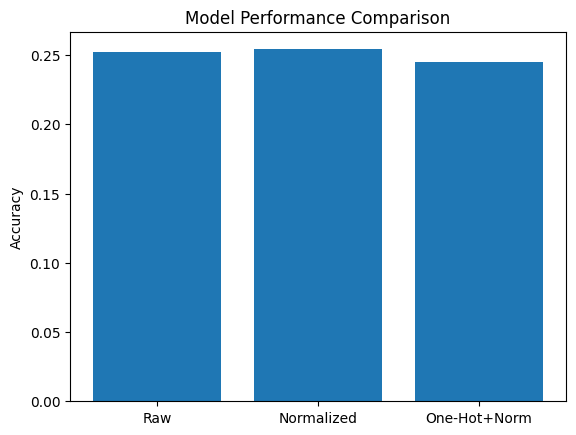

In [25]:
# adapted from Copilot to compare accuracies

acc_raw = accuracy_score(y_test, tlp_raw.predict(X_test))
acc_norm = accuracy_score(y_test, tlp_norm.predict(X_test))
acc_onehot = accuracy_score(y_test, tlp_onehot.predict(X_test))

print(f"Raw Data Accuracy: {acc_raw:.4f}")
print(f"Normalized Data Accuracy: {acc_norm:.4f}")
print(f"One-Hot + Normalized Accuracy: {acc_onehot:.4f}")

plt.bar(["Raw", "Normalized", "One-Hot+Norm"], [acc_raw, acc_norm, acc_onehot])
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.show()

The bar graph above compares the accuracy of the three models. The normalized and one-hot encoded + normalized models achieved slightly higher accuracies (~25.5%) than the raw data model (~24.5%). While the improvement is relatively small, it confirms that preprocessing, particularly normalization, which contributes to more stable and effective learning. The results suggest that proper feature scaling and encoding help optimize model performance, even if the gains appear marginal for this dataset.

Let's dig in deeper and really look at a proper statistical comparison beyond comparing accuracy scores from a standalone approach.

In [ ]:
# Adapted from Statistical Comparison section of ICA3_MachineLearning.ipynb

# build the full datasets
X_raw_full      = X.values.astype(float)
X_norm_full     = StandardScaler().fit_transform(X)
X_norm_ohe_full = StandardScaler().fit_transform(pd.get_dummies(X))
y_full = pd.qcut(df_enc["ChildPoverty"], q=4, labels=False).values


# cross evaluation
cv = StratifiedShuffleSplit(n_splits=10, train_size=0.10, test_size=0.90, random_state=42)

# created a cv_eval instead of using cross_eval_score because we need to balance the classes first
def cv_eval(X_balanced, y_balanced):
    scores = []
    for tr, te in cv.split(X_balanced, y_balanced):
        model = TwoLayerPerceptron(n_hidden=30, epochs=100, eta=0.001, minibatch_size=64)
        model.fit(X_balanced[tr], y_balanced[tr])
        pred = model.predict(X_balanced[te])
        scores.append( accuracy_score(y_balanced[te], pred) )
    return np.array(scores)

# everything beneath here is new code for ICA3_MachineLearning.ipynb (Statistical Comparison section)
evals_raw      = cv_eval(X_raw_full,      y_full)
evals_norm     = cv_eval(X_norm_full,     y_full)
evals_norm_ohe = cv_eval(X_norm_ohe_full, y_full)

print("Raw:", evals_raw)
print("Norm:", evals_norm)
print("OHE:", evals_norm_ohe)

t = 2.26 / np.sqrt(10)

e1 = (1-evals_raw)      - (1-evals_norm)      # raw vs norm
e2 = (1-evals_norm)     - (1-evals_norm_ohe)  # norm vs norm+ohe
e3 = (1-evals_raw)      - (1-evals_norm_ohe)  # raw vs norm+ohe

dbar1 = np.mean(e1)
dbar2 = np.mean(e2)
dbar3 = np.mean(e3)

sdtot1 = np.std(e1)
sdtot2 = np.std(e2)
sdtot3 = np.std(e3)

print("\n95% CI ranges:")
print("Raw vs Normalized:     ", dbar1 - t*sdtot1, "to", dbar1 + t*sdtot1)
print("Normalized vs OHE:     ", dbar2 - t*sdtot2, "to", dbar2 + t*sdtot2)
print("Raw vs OHE:            ", dbar3 - t*sdtot3, "to", dbar3 + t*sdtot3)


Raw: [0.25061891 0.24959504 0.24959504 0.24987011 0.24991595 0.24987011
 0.25061891 0.24959504 0.24987011 0.25061891]
Norm: [0.97567163 0.97967542 0.97855986 0.97620649 0.97949204 0.97881965
 0.97875852 0.97672606 0.97613008 0.97658853]
OHE: [0.97626761 0.97554937 0.98059232 0.97764296 0.97981295 0.97982823
 0.97911    0.97651212 0.97660381 0.97911   ]

95% CI ranges:
Raw vs Normalized:      0.7264766908080175 to 0.7288153413445543
Normalized vs OHE:      -0.0007875612927980964 to 0.001667783793485807
Raw vs OHE:             0.7268614270149492 to 0.7293108276383105


Both the normalized and normalized+one-hot models perform significantly better than the raw model. However, the comparison between normalized and normalized & one-hot encoding includes 0, indicating no statistically significant difference between those two preprocessing pipelines. Therefore, normalization alone achieves essentially the same performance as normalization & one-hot encoding.

*Use one-hot encoding and normalization on the dataset for the remainder of this lab assignment.*

### **3. Modeling**


3.1 Add support for a third layer in the multi-layer perceptron. Add support for saving (and plotting after training is completed) the average magnitude of the gradient for each layer, for each epoch (like we did in the flipped module for back propagation). For magnitude calculation, you are free to use either the average absolute values or the L1/L2 norm.
- Quantify the performance of the model and graph the magnitudes for each layer versus the number of epochs.

In [101]:
class ThreeLayerPerceptron(object):
    def __init__(self, n_hidden1=30, n_hidden2=20, C=0.0, epochs=500, eta=0.001, minibatch_size=64, random_state=None):
        np.random.seed(random_state)
        self.n_hidden1 = n_hidden1
        self.n_hidden2 = n_hidden2
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta
        self.minibatch_size = minibatch_size

    @staticmethod
    def _encode_labels(y):
        """Encode labels into one-hot representation."""
        return pd.get_dummies(y).values.T

    def initialize_weights(self, n_features, n_output):
        """Initialize weights using Glorot initialization."""
        limit_1 = np.sqrt(6 / (n_features + self.n_hidden1))
        limit_2 = np.sqrt(6 / (self.n_hidden1 + self.n_hidden2))
        limit_3 = np.sqrt(6 / (self.n_hidden2 + n_output))

        W1 = np.random.uniform(-limit_1, limit_1, (self.n_hidden1, n_features + 1))
        W2 = np.random.uniform(-limit_2, limit_2, (self.n_hidden2, self.n_hidden1 + 1))
        W3 = np.random.uniform(-limit_3, limit_3, (n_output, self.n_hidden2 + 1))
        
        b1 = np.zeros((self.n_hidden1, 1))
        b2 = np.zeros((self.n_hidden2, 1))
        b3 = np.zeros((n_output, 1))
        
        return W1, W2, W3, b1, b2, b3
    
    @staticmethod
    def _sigmoid(z):
        """Sigmoid activation function."""
        return expit(z)
    
    @staticmethod
    def _softmax(z):
        """Softmax activation function (for cross-entropy)."""
        exp_values = np.exp(z - np.max(z, axis=0, keepdims=True))  # stability
        return exp_values / np.sum(exp_values, axis=0, keepdims=True)
    
    @staticmethod
    def _cross_entropy_loss(Y_enc, A4):
        """Cross-entropy loss function."""
        m = Y_enc.shape[1]
        cost = -np.sum(Y_enc * np.log(A4 + 1e-8)) / m  # add small epsilon for stability
        return cost
    
    def _cost(self, A4, Y_enc, W1, W2, W3):
        """Compute the cost function with regularization."""
        cost = self._cross_entropy_loss(Y_enc, A4)
        L2_term = self._L2_reg(self.l2_C, W1, W2, W3)
        return cost + L2_term
    
    def _L2_reg(self, lambda_, W1, W2, W3):
        """Compute L2 regularization cost."""
        return (lambda_ / 2.0) * (np.sum(W1[:, 1:] ** 2) + np.sum(W2[:, 1:] ** 2) + np.sum(W3[:, 1:] ** 2))
    
    def _feedforward(self, X, W1, W2, W3, b1, b2, b3):
        """Compute the feedforward step."""
        A1 = self._add_bias_unit(X)
        Z1 = W1 @ A1.T + b1
        A2 = self._sigmoid(Z1)
        A2 = self._add_bias_unit(A2.T)
        Z2 = W2 @ A2.T + b2
        A3 = self._sigmoid(Z2)
        A3 = self._add_bias_unit(A3.T)
        Z3 = W3 @ A3.T + b3
        A4 = self._softmax(Z3)
        return A1, Z1, A2, Z2, A3, Z3, A4
    
    def _add_bias_unit(self, X):
        """Add bias unit to the input data."""
        ones = np.ones((X.shape[0], 1))
        return np.hstack((ones, X))
    
    def _get_gradient(self, A1, A2, A3, A4, Z1, Z2, Z3, Y_enc, W1, W2, W3):
        """Compute gradient step using backpropagation."""
        V3 = A4 - Y_enc
        delta3 = W3[:, 1:].T @ V3
        delta3_t = delta3.T
        A3_nobias = A3[:, 1:]
        V2 = A3_nobias * (1 - A3_nobias) * delta3_t
        
        delta2 = W2[:, 1:].T @ V2.T
        delta2_t = delta2.T
        A2_nobias = A2[:, 1:]
        V1 = A2_nobias * (1 - A2_nobias) * delta2_t
        
        gradW3 = V3 @ A3
        gradW2 = V2.T @ A2
        gradW1 = V1.T @ A1
        
        gradb3 = np.sum(V3, axis=1).reshape((-1, 1))
        gradb2 = np.sum(V2.T, axis=1).reshape((-1, 1))
        gradb1 = np.sum(V1.T, axis=1).reshape((-1, 1))
        
        gradW1[:, 1:] += self.l2_C * W1[:, 1:]
        gradW2[:, 1:] += self.l2_C * W2[:, 1:]
        gradW3[:, 1:] += self.l2_C * W3[:, 1:]
        
        return gradW1, gradW2, gradW3, gradb1, gradb2, gradb3
    
    def fit(self, X, y):
        Y_enc = self._encode_labels(y)
        n_features = X.shape[1]
        n_output = Y_enc.shape[0]

        W1, W2, W3, b1, b2, b3 = self.initialize_weights(n_features, n_output)
        cost_history = []
        grad_mag1, grad_mag2, grad_mag3 = [], [], []

        for epoch in range(self.epochs):
            minibatch_cost = 0
            epoch_grad1, epoch_grad2, epoch_grad3 = [], [], []

            permutation = np.random.permutation(X.shape[0])
            X_shuffled = X[permutation]
            Y_enc_shuffled = Y_enc[:, permutation]

            for i in range(0, X.shape[0], self.minibatch_size):
                X_batch = X_shuffled[i:i+self.minibatch_size]
                Y_batch = Y_enc_shuffled[:, i:i+self.minibatch_size]

                A1, Z1, A2, Z2, A3, Z3, A4 = self._feedforward(X_batch, W1, W2, W3, b1, b2, b3)
                minibatch_cost = self._cost(A4, Y_batch, W1, W2, W3)

                gradW1, gradW2, gradW3, gradb1, gradb2, gradb3 = self._get_gradient(
                    A1, A2, A3, A4, Z1, Z2, Z3, Y_batch, W1, W2, W3
                )

                # Track gradient magnitudes per minibatch
                epoch_grad1.append(np.linalg.norm(gradW1))
                epoch_grad2.append(np.linalg.norm(gradW2))
                epoch_grad3.append(np.linalg.norm(gradW3))

                # Update parameters
                W1 -= self.eta * gradW1
                W2 -= self.eta * gradW2
                W3 -= self.eta * gradW3
                b1 -= self.eta * gradb1
                b2 -= self.eta * gradb2
                b3 -= self.eta * gradb3

            # Record average gradient magnitude for each epoch
            grad_mag1.append(np.mean(epoch_grad1))
            grad_mag2.append(np.mean(epoch_grad2))
            grad_mag3.append(np.mean(epoch_grad3))
            cost_history.append(minibatch_cost)

        # Store results
        self.W1, self.W2, self.W3 = W1, W2, W3
        self.b1, self.b2, self.b3 = b1, b2, b3
        self.cost_ = cost_history
        self.grad_mag1_, self.grad_mag2_, self.grad_mag3_ = grad_mag1, grad_mag2, grad_mag3
        return self
        
    def predict(self, X):
        _, _, _, _, _, _, A4 = self._feedforward(X, self.W1, self.W2, self.W3, self.b1, self.b2, self.b3)
        return np.argmax(A4, axis=0)
    
    def plot_gradient_flow(self):
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(len(self.cost_)), self.cost_, label="Loss", color='tab:blue')
        plt.xlabel("Epochs")
        plt.ylabel("Cost (Loss)")
        plt.title("Loss Function vs Epochs")
        plt.legend()
        
        plt.subplot(1, 2, 2)
        epochs = range(len(self.grad_mag1_))
        plt.plot(epochs, self.grad_mag1_, label='W1', color='tab:blue')
        plt.plot(epochs, self.grad_mag2_, label='W2', color='tab:orange')
        plt.plot(epochs, self.grad_mag3_, label='W3', color='tab:green')
        plt.xlabel("Epochs")
        plt.ylabel("Average Gradient Magnitudes")
        plt.title("Gradient Magnitudes During Training")
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        
def train_evaluate_model(X_train, y_train, X_test, y_test, n_hidden1, n_hidden2, **params):
    model = ThreeLayerPerceptron(n_hidden1=n_hidden1, n_hidden2=n_hidden2, epochs=100, eta=0.001, minibatch_size=64)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    print(f"Training Accuracy: {train_acc}")
    print(f"Test Accuracy: {test_acc}")
    
    model.plot_gradient_flow()
    
    return model

Training and evaluating Three-Layer Perceptron with 30 and 20 hidden units:
Training Accuracy: 0.9945941278065631
Test Accuracy: 0.9917480401595379


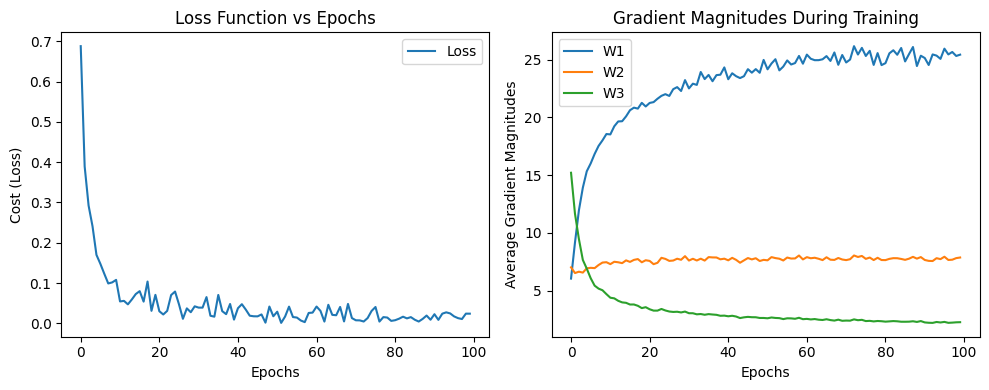

In [102]:
params = {'epochs': 500,
          'eta': 0.001,
          'minibatch_size': 64,
          'C': 0.01,
          'random_state': 42,
}

print("Training and evaluating Three-Layer Perceptron with 30 and 20 hidden units:")
hidden_3 = [30,20]
three_layer_model = train_evaluate_model(X_train_onehot_norm, y_train_balanced, X_test_onehot_norm, y_test, hidden_3[0], hidden_3[1], **params)


3.2 Repeat the previous step, adding support for a fourth layer.

3.3 Repeat the previous step, adding support for a fifth layer. 

3.4 Implement an adaptive learning technique that was discussed in lecture and use it on the five layer network (choose either RMSProp or AdaDelta). Discuss which adaptive method you chose. Compare the performance of your five layer model with and without the adaptive learning strategy. **Do not use AdaM for the adaptive learning technique as it is part of the exceptional work.**

### **4. Exceptional Work**

Implement adaptive momentum (AdaM) in the five layer neural network and quantify the performance compared to other methods.  